In [4]:

import pandas as pd
import numpy as np
import seaborn as sns
import os 

from string import punctuation
from matplotlib import pyplot as plt

from sklearn import metrics, mixture, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import gensim
from gensim.models import word2vec

import nltk, string
from nltk.corpus import stopwords
from nltk.cluster import KMeansClusterer, cosine_distance, euclidean_distance
nltk.download('stopwords')
nltk.download('punkt')


ModuleNotFoundError: No module named 'seaborn'

In [3]:

train = pd.read_csv(os.path("\\data\\train.csv"))
train_text = train["text"]

test = pd.read_csv("\\data\\test.csv")
test_label = test["label"]
test_text = test["text"]
test.head()


FileNotFoundError: [Errno 2] No such file or directory: '\\data\\train.csv'

In [164]:

def all_stop_list(additional=None, include_defaults=True):
    """
    Generate a custom list of stop words.

    Parameters:
    - additional (list of str): Additional words to include as stop words.
    - include_defaults (bool): Whether to include default English stop words from NLTK and CountVectorizer.

    Returns:
    - list of str: The combined list of stop words.
    """
    all_stop_words = set()

    # Include default stop words from NLTK and CountVectorizer
    if include_defaults:
        defaults_nltk = set(stopwords.words('english'))
        vectorizer = CountVectorizer(stop_words='english')
        defaults_cv = set(vectorizer.get_stop_words())
        all_stop_words = defaults_nltk.union(defaults_cv)

    # Add any additional specified stop words
    if additional:
        all_stop_words = all_stop_words.union(additional)

    return list(all_stop_words)

def fit_vectorizer(train_text, test_text, vectorizer=TfidfVectorizer, extra_stop_words=["like", "would"]):
    # remove new line chars to prevent tokenization errors
    train_text = train_text.apply(lambda doc: ' '.join(' '.join(doc.split('\n')).split('\\n')))
    test_text = test_text.apply(lambda doc: ' '.join(' '.join(doc.split('\n')).split('\\n')))

    all_stop_words = all_stop_list(additional=extra_stop_words)

    # set vectorizer params
    vec_params = {
        'stop_words':all_stop_words,            # nltk stopwords + custom stopwords
        'min_df': 5,                            # token must appear in at least 3 docs
        'strip_accents':'unicode',              # token normalization by stripping accents and other punct
        'token_pattern':r'\b[a-zA-Z]{3,}\b'}    # only keep non-numeric tokens over 2 letters

    # intialize and fit tfidf vectorizer
    tfidf_vec = vectorizer(**vec_params)
    tfidf_vec = tfidf_vec.fit(train_text)

    return tfidf_vec

def gmm_grid_search(train_text, test_text):

    # Grid search to find optimal params
    tfidf_vec= fit_vectorizer(train_text, test_text)

    # transform train data to get doc term matrix
    dtm = tfidf_vec.transform(train_text)

    # We use a small scope of grid search to find the best parameters of GMM
    lowest_bic = np.infty   # initial BIC is set to infinity
    best_gmm = None

    n_components_range = range(2,5)
    cv_types = ['spherical', 'tied', 'diag', 'full']

    # The covariance type, for details check https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture.aic
    #‘full’: each component has its own general covariance matrix.
    #‘tied’: all components share the same general covariance matrix.
    #‘diag’: each component has its own diagonal covariance matrix.
    #‘spherical’: each component has its own single variance.

    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                        n_init=2,
                                        covariance_type=cv_type, random_state=42)
            gmm.fit(dtm.toarray())

            bic = gmm.bic(dtm.toarray())  # get Model BIC

            if bic < lowest_bic:  # save the model with lowest BIC sofar
                lowest_bic = bic
                best_gmm = gmm

    # lowest_bic
    return best_gmm

def format_confusion_matrix(test_label, predicted, num_clusters=4, num_top_words=10):

    # create df with ground truth labels and predicted cluster ids
    confusion_df = pd.DataFrame(list(zip(test_label.values, predicted)), columns = ["label", "cluster"])
    # use confusion matrix to map cluster id to true labels by majority vote
    cluster_labels = pd.crosstab( index=confusion_df.cluster, columns=confusion_df.label)
    cluster_dict = {i:cluster_labels.loc[i].idxmax() for i in range(num_clusters)}
    # Map true label to cluster id
    predicted_topic = [cluster_dict[i]  for i in predicted]

    # print classification report
    best_report = metrics.classification_report(test_label.values, predicted_topic)
    print("")
    print(best_report)

    return cluster_dict

def plot_pca(test_dtm, predicted, n=2):
    tfidf_vectorizer = fit_vectorizer(train_text, test_text)

    # transform train data to get doc term matrix
    dtm = tfidf_vectorizer.transform(train_text)
    test_dtm = tfidf_vectorizer.transform(test_text)

    pca = PCA(n_components=n)
    X = pca.fit_transform(test_dtm.toarray())

    plt.figure(figsize=(16, 4))
    plt.subplot(1,2,1)
    sns.scatterplot(x=X[:,0], y=X[:,1], hue =  test["label"], palette=['green','orange','blue','red'])
    plt.title("Ground Truth")

    plt.subplot(1,2,2)
    sns.scatterplot(x=X[:,0], y=X[:,1], hue = predicted, palette=['blue','red','green','orange'])
    plt.title("Predicted")
    plt.show()

def cluster_kmean(train_text, test_text, test_label):

    num_clusters = 4
    # fit vectorizer
    tfidf_vectorizer = fit_vectorizer(train_text, test_text)

    # transform train data to get doc term matrix
    dtm = tfidf_vectorizer.transform(train_text)

    # init clustering model with 4 clusters using cosine distance
    # repeat clustering 20x with new initial centroids
    clusterer = KMeansClusterer(num_clusters, cosine_distance, repeats=20)
    # assign cluster labels
    clusters = clusterer.cluster(dtm.toarray(), assign_clusters=True)

    # each row is a cluster, and each column is a feature (word)
    centroids = np.array(clusterer.means())
    # argsort sort the matrix in ascending order and return locations of features before sorting
    sorted_centroids = centroids.argsort()[:, ::-1]    #  reverse the order
    voc_lookup = tfidf_vectorizer.get_feature_names_out()

    # print top 20 words in each cluster
    for i in range(num_clusters):
        # get words with top 20 tf-idf weight in the centroid
        top_words = [ voc_lookup[word_index] for word_index in sorted_centroids[i, :20] ]
        print("Cluster %d:\n %s " % (i, "; ".join(top_words)))

    # transform test set with fitted vectorizer and predict clusters
    test_dtm = tfidf_vectorizer.transform(test_text)
    predicted = [clusterer.classify(v) for v in test_dtm.toarray()]

    confusion_matrix(test_label, predicted, num_clusters)

    return predicted, test_dtm

def cluster_gmm(train_text, test_text, test_label, best_gmm=None):

    num_clusters = 4

    tfidf_vectorizer = fit_vectorizer(train_text, test_text)

    test_dtm = tfidf_vectorizer.transform(test_text)

    if not best_gmm:
        best_gmm = gmm_grid_search(train_text, test_text)

    predicted = best_gmm.predict(test_dtm.toarray())

    confusion_matrix(test_label, predicted, num_clusters)

    return predicted, test_dtm

def cluster_lda(train_text, test_text, test_label):
    num_topics = 4
    num_top_words = 30

    # Assuming the fit_vectorizer function correctly initializes, fits, and returns a TfidfVectorizer instance
    ct_vectorizer = fit_vectorizer(train_text, test_text, vectorizer=CountVectorizer)

    # Transform the test text to a TF-IDF representation
    dtm = ct_vectorizer.transform(train_text)

    test_dtm = ct_vectorizer.transform(test_text)

    # Initialize the LDA model
    lda = LatentDirichletAllocation(n_components=num_topics, max_iter=30, learning_offset=40.0, learning_method='online',
                                    verbose=1, evaluate_every=5, n_jobs=1, random_state=0).fit(dtm)
    predicted_labels = lda.transform(test_dtm)

    # Print the top words for each topic
    # Generate topic assignment for each test document
    tf_feature_names = ct_vectorizer.get_feature_names_out()
    predicted = [label.argmax() for label in predicted_labels]

    # Display the confusion matrix
    cluster_dict = format_confusion_matrix(test_label, predicted)

    for topic_idx, topic in enumerate(lda.components_):
        words = [(tf_feature_names[i], f'{topic[i]:.2f}') for i in topic.argsort()[::-1][0:num_top_words]]
        print(f"Topic {topic_idx}, assigned to test label {cluster_dict[topic_idx]}: {words}\n")

    return predicted, test_dtm


## K-Means Clustering


Cluster 0:
 water; energy; light; earth; number; mass; equation; one; speed; gas; air; two; force; used; sun; answer; space; heat; universe; time 
Cluster 1:
 get; people; know; want; think; one; good; com; time; work; job; need; money; help; business; find; really; www; make; way 
Cluster 2:
 weight; get; body; help; doctor; blood; eat; pain; take; also; day; diet; one; could; good; fat; need; know; may; exercise 
Cluster 3:
 god; jesus; bible; people; believe; religion; christians; one; world; christian; think; life; church; man; question; know; many; say; faith; word 
              precision    recall  f1-score   support

           1       0.90      0.51      0.65       332
           2       0.94      0.64      0.76       314
           3       0.85      0.77      0.81       355
           7       0.47      0.94      0.63       273

    accuracy                           0.71      1274
   macro avg       0.79      0.72      0.71      1274
weighted avg       0.80      0.71      0.7

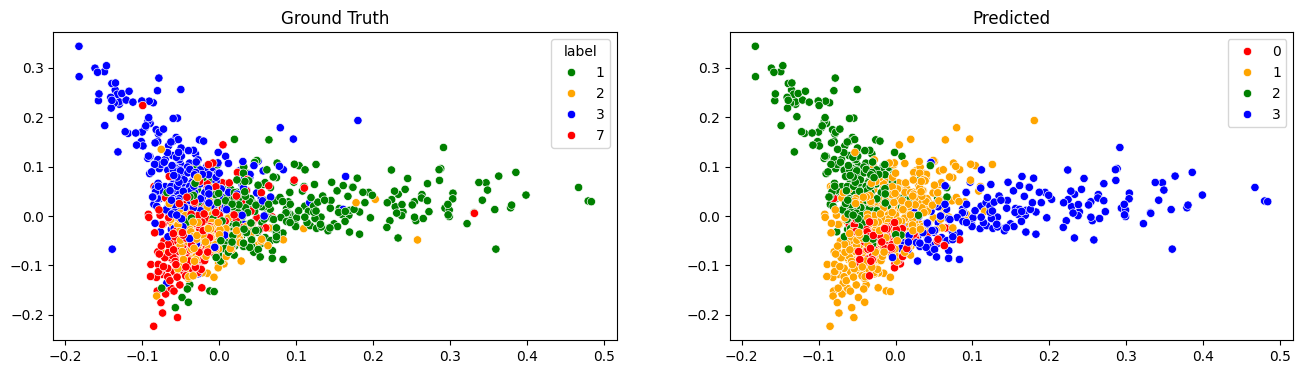

In [4]:

predicted, test_dtm = cluster_kmean(train_text, test_text, test_label)
plot_pca(test_dtm, predicted)


## GMM Clustering + Grid Search

In [6]:


cluster_gmm(train_text, test_text, test_label)
plot_pca(test_dtm, test, predicted)


KeyboardInterrupt: 

## LDA Clustering

In [163]:

predicted, test_dtm = cluster_lda(train_text, test_text, test_label)


iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30, perplexity: 2335.8045
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30, perplexity: 2306.1691
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30, perplexity: 2298.3358
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30, perplexity: 2294.7422
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30, perplexity: 2292.6111
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_ite

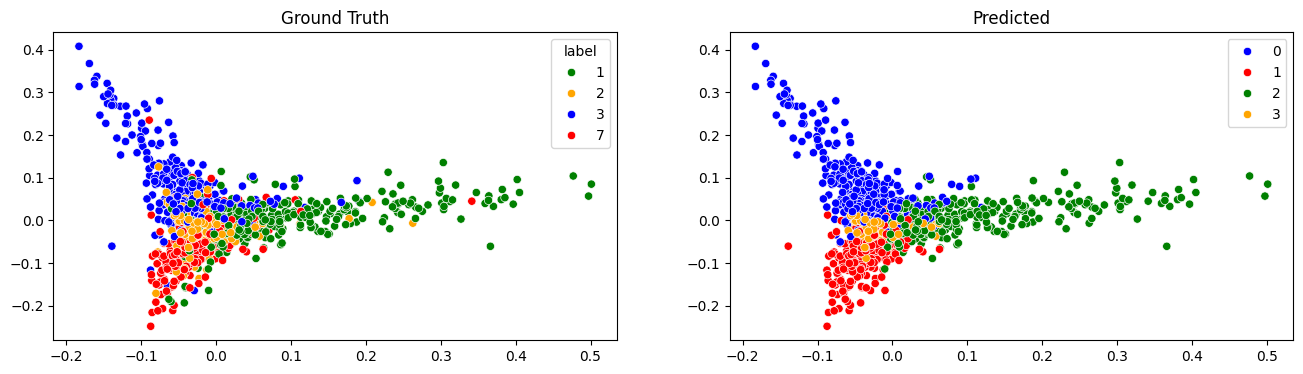

In [165]:

plot_pca(test_dtm, predicted)



## What preprocessing parameters are better and why.

Preprocessing by stripping all punctuation and only keeping non-numeric characters over 2 letters worked well by reducing variance within clusters and normalizing the documents. Also, after looking at the top 20 words for each cluster, additional stop words ['like','would'] were added. This further reduced variance in the data and helps to reduce overlapping features/similarity between clusters. The high variance is shown in the scatter plots below.    
    
## Which distance measure is better and why it is better.

Cosine distance similarity was more effective that Euclidean because the decision space had large dimensions, and there is a lot of overlap between text vectors due to common words such as 'person' or 'where'. In this case, cosine similarity is better because it considers the angle between two vectors, unlike Euclidean similiarity that considers vector magnitude. This means cosine is better for determining the semantic components of text for clustering, where Euclidean is suited for tasks with token raw frequency.    

## Could you assign a meaningful name to each cluster? Discuss how you interpret each cluster.
  
Topic names can be assigned by looking at the most popular words for each cluster:  
Cluster 0:  water; energy; light; earth; number; one; used; air; mass; two; speed; gas; equation; force; also; answer; heat; sun; use; first   
Cluster 1:  http; com; www; business; credit; money; company; get; good; find; pay; need; want; one; yahoo; help; tax; card; home; site   
Cluster 2:  get; people; know; help; think; good; one; time; want; really; weight; need; work; take; could; make; day; also; feel; way   
Cluster 3: god; people; jesus; bible; believe; religion; christians; one; man; life; think; world; christian; church; many; know; question; say; love; christ

Based on the semantic similarity of the clusters, they could be labeled as:  
0: 'science and math'  
1: 'business'   
2: 'health and wellness'  
3: 'religion'  

These labels were chosen based on the percieved common topic between the words, as well as what defined them the best without being similar to another cluster. For example, assigning topic 0 as 'tech' might be too vague and relate to a lot of text in topic 1 as well.  
